In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath(".."))

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option('display.max_columns', None)

## 1. Load Data

In [2]:
import src.features
import importlib
importlib.reload(src.features)
from src.features import extract_user_attributes, generate_training_data

print("Regenerating Training Features from Raw Data (Snapshot Approach)...")
train_raw_path = '../data/train.parquet'
train_df_raw = pd.read_parquet(train_raw_path)
train_df_raw = extract_user_attributes(train_df_raw)

# --- SMART DATA GENERATION ---
# We use the strategy that gave us the All-Time High (0.648).
# - Churners: Snapshots at 1, 3, 7 days before churn.
# - Non-Churners: Random active snapshots + "Dormancy" snapshots (after last event).
# This aligns the training distribution with the test set (where many users are dormant).

df = generate_training_data(train_df_raw)

print(f"Dataset Shape: {df.shape}")
print(f"Churn Rate: {df['target'].mean():.2%}")

print("\nAvg Gap for Non-Churners (Target 0) - Should include large gaps (Dormancy):")
print(df[df['target']==0]['days_since_last_session'].describe())

df.head()

Regenerating Training Features from Raw Data (Snapshot Approach)...
Generated 85807 snapshots.
Class Balance: 12.28%
Generated 85807 snapshots.
Class Balance: 12.28%
Dataset Shape: (85807, 43)
Churn Rate: 12.28%

Avg Gap for Non-Churners (Target 0) - Should include large gaps (Dormancy):
count    75268.000000
mean        15.085518
std         13.654632
min          0.000000
25%          2.849997
50%         11.000000
75%         26.000000
max         45.878287
Name: days_since_last_session, dtype: float64
Dataset Shape: (85807, 43)
Churn Rate: 12.28%

Avg Gap for Non-Churners (Target 0) - Should include large gaps (Dormancy):
count    75268.000000
mean        15.085518
std         13.654632
min          0.000000
25%          2.849997
50%         11.000000
75%         26.000000
max         45.878287
Name: days_since_last_session, dtype: float64


,userId,cutoff_ts,level,downgrade,account_lifetime,avg_songs_per_day,thumbs_ratio,trend_songs_7d_vs_30d,trend_listen_time_7d_vs_30d,trend_errors_7d_vs_30d,avg_days_between_sessions,sessions_per_day,thumbs_up_per_day,thumbs_down_per_day,ads_per_day,errors_per_day,listen_time_per_day,log_songs_last_7d,log_errors_last_7d,log_listen_time_last_7d,log_songs_last_14d,log_errors_last_14d,log_listen_time_last_14d,log_songs_last_30d,log_errors_last_30d,log_listen_time_last_30d,days_since_last_session,avg_songs_per_session,avg_session_duration,songs_per_minute,last_session_errors,last_session_songs,last_session_length,last_session_downgrade,exploration_ratio,diversity_ratio_30d,exploration_rate,hate_ratio_7d,frustration_score,recency_frequency_ratio,session_velocity,state_freq,target
0,1000025,2018-10-11 20:33:05,paid,0,93.460382,2.426729,0.862500,1.484519,1.508164,0.000000,8.496398,0.110155,0.548390,0.100627,0.041474,0.000000,7.855292,5.894403,0.000000,11.427697,6.883463,0.000000,12.403089,6.883463,0.000000,12.403089,0.001887,88.636364,22141.076842,0.240136,0,23,6423.78710,0,1.712635,0.907787,0.907787,0.005510,0.000000,0.000157,1.485067,0.012790,1
1,1000025,2018-10-15 20:33:05,paid,0,97.460382,2.521418,0.869048,1.380167,1.422792,0.000000,7.496952,0.124015,0.554698,0.096731,0.039822,0.000000,7.968601,5.966147,0.000000,11.524246,7.028201,0.000000,12.557912,7.028201,0.000000,12.557912,0.002118,86.692308,21871.927535,0.237768,0,7,2218.21072,0,1.589003,0.904255,0.904255,0.000000,0.000000,0.000151,1.380608,0.012790,1
2,1000025,2018-10-17 20:33:05,paid,0,99.460382,2.736544,0.877551,1.500276,1.533601,3.846154,6.216274,0.147788,0.618455,0.103906,0.039044,0.009905,8.197200,6.300786,0.693147,11.848021,6.961296,0.693147,12.489691,7.280008,0.693147,12.806691,0.000336,90.625000,22790.509112,0.238547,0,116,28372.37514,0,1.727920,0.892488,0.892488,0.001835,0.001029,0.000020,1.500648,0.012790,1
3,1000035,2018-10-31 10:54:56,paid,0,48.643449,2.704002,0.850746,1.276719,1.249365,0.000000,3.474532,0.248430,0.764625,0.166609,0.095963,0.000000,8.137880,5.402677,0.000000,10.878817,6.327937,0.000000,11.834005,6.541030,0.000000,12.042460,2.698958,49.428571,12129.516942,0.244418,0,153,37468.87435,0,1.448349,0.942280,0.942280,0.013514,0.000000,0.179931,1.277383,0.011046,0
4,1000035,2018-11-06 19:28:13,paid,0,54.999896,2.660511,0.859155,0.285560,0.288477,0.000000,3.666660,0.237329,0.736823,0.149036,0.085522,0.000000,8.091997,3.988984,0.000000,9.484260,5.616771,0.000000,11.100298,6.610696,0.000000,12.113621,3.840139,49.666667,12197.555489,0.244231,0,53,13150.09515,0,0.348759,0.942127,0.942127,0.000000,0.000000,0.240009,0.285699,0.011046,0


## 2. Preprocessing & Splitting

In [3]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

cols_to_drop = ["target", "userId", "cutoff_ts"]
X = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
y = df['target']

# Define potential categorical columns
potential_categorical_cols = ['gender', 'level', 'platform']
# Only keep those that exist in the dataframe (we might have pruned some in features.py)
categorical_cols = [c for c in potential_categorical_cols if c in X.columns]

numerical_cols = [c for c in X.columns if c not in categorical_cols]  # type: ignore

print(f"Categorical Columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical Columns ({len(numerical_cols)}): {numerical_cols[:5]} ...")

# GroupShuffleSplit to ensure no user appears in both train and test (prevent leakage)
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=RANDOM_SEED)
train_idx, test_idx = next(splitter.split(X, y, groups=df['userId']))

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

print(f"\nTraining Shape: {X_train.shape}")
print(f"Test Shape: {X_test.shape}")
print(f"Train Churn Rate: {y_train.mean():.2%}")
print(f"Test Churn Rate: {y_test.mean():.2%}")

Categorical Columns (1): ['level']
Numerical Columns (39): ['downgrade', 'account_lifetime', 'avg_songs_per_day', 'thumbs_ratio', 'trend_songs_7d_vs_30d'] ...

Training Shape: (68601, 40)
Test Shape: (17206, 40)
Train Churn Rate: 12.42%
Test Churn Rate: 11.75%


In [4]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
print(f"Processed Feature Matrix Shape: {X_train_processed.shape}")

Processed Feature Matrix Shape: (68601, 41)


## 3. Baseline Model Evaluation

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# We REMOVE explicit class weights.
# The "Smart Sampling" (Dormancy Snapshots) handles the distribution better.
# Stacking with Logistic Regression will handle the final calibration.

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED),
    "LightGBM": LGBMClassifier(random_state=RANDOM_SEED, verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=RANDOM_SEED)
}

def evaluate_models(models, X, y, preprocessor):
    results = []
    for name, model in models.items():
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])
        
        # Cross-validation (5-fold)
        cv_results = cross_validate(clf, X, y, cv=5, scoring=['f1', 'roc_auc', 'accuracy'])
        
        results.append({
            "Model": name,
            "F1 Score (Mean)": cv_results['test_f1'].mean(),
            "F1 Score (Std)": cv_results['test_f1'].std(),
            "ROC-AUC (Mean)": cv_results['test_roc_auc'].mean(),
            "ROC-AUC (Std)": cv_results['test_roc_auc'].std(),
            "Accuracy (Mean)": cv_results['test_accuracy'].mean(),
            "Accuracy (Std)": cv_results['test_accuracy'].std(),
        })
        print(f"Evaluated {name}...")
        
    return pd.DataFrame(results).sort_values(by="F1 Score (Mean)", ascending=False)

results_df = evaluate_models(models, X_train, y_train, preprocessor)
results_df

Evaluated Logistic Regression...
Evaluated Random Forest...
Evaluated Random Forest...
Evaluated XGBoost...
Evaluated XGBoost...
Evaluated LightGBM...
Evaluated LightGBM...
Evaluated CatBoost...
Evaluated CatBoost...


,Model,F1 Score (Mean),F1 Score (Std),ROC-AUC (Mean),ROC-AUC (Std),Accuracy (Mean),Accuracy (Std)
2,XGBoost,0.354132,0.011671,0.865179,0.004760,0.883384,0.001799
4,CatBoost,0.344114,0.014194,0.878751,0.003456,0.886168,0.001338
3,LightGBM,0.338908,0.010752,0.878841,0.005580,0.886766,0.001164
1,Random Forest,0.273256,0.016027,0.855085,0.004534,0.883879,0.001495
0,Logistic Regression,0.272649,0.009054,0.854117,0.005977,0.883996,0.001095


In [6]:
# --- FEATURE PRUNING (SPEED UP) ---
from sklearn.preprocessing import OrdinalEncoder

print("\n✂️ Pruning Low-Importance Features to Speed Up Optimization...")

# 1. Quick Preprocessing for Selection (Ordinal Encoding for Categoricals)
# We work on a copy to avoid messing up the main dataframe yet
X_train_sel = X_train.copy()

# Handle Categoricals
# We use the existing 'categorical_cols' list
valid_cat_cols = [c for c in categorical_cols if c in X_train_sel.columns]
if valid_cat_cols:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train_sel[valid_cat_cols] = oe.fit_transform(X_train_sel[valid_cat_cols])

# 2. Train Fast XGBoost
# We use a simple model to gauge importance
sel_model = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=RANDOM_SEED, n_jobs=-1)
sel_model.fit(X_train_sel, y_train)

# 3. Get Importances
importances = pd.DataFrame({
    'feature': X_train_sel.columns,
    'importance': sel_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top 10 Features:")
print(importances.head(10))

# 4. Drop Zero Importance Features
# We drop features that the model didn't use at all (Importance = 0)
features_to_prune = importances[importances['importance'] == 0]['feature'].tolist()

if features_to_prune:
    print(f"\nDropping {len(features_to_prune)} features with 0 importance: {features_to_prune}")
    X_train = X_train.drop(columns=features_to_prune)
    X_test = X_test.drop(columns=features_to_prune)
    
    # 5. RE-INITIALIZE PREPROCESSOR
    # Update column lists
    numerical_cols = [c for c in X_train.columns if c not in categorical_cols]  # type: ignore
    # Update categorical_cols just in case one was dropped
    categorical_cols = [c for c in categorical_cols if c in X_train.columns]
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, numerical_cols),
            ('cat', cat_transformer, categorical_cols)
        ]
    )
    print(f"New Feature Count: {X_train.shape[1]}")
else:
    print("No features with 0 importance found.")


✂️ Pruning Low-Importance Features to Speed Up Optimization...
Top 10 Features:
                     feature  importance
17   log_listen_time_last_7d    0.238563
24   days_since_last_session    0.138794
20  log_listen_time_last_14d    0.055544
38          session_velocity    0.028072
12               ads_per_day    0.026797
0                      level    0.025569
4               thumbs_ratio    0.022523
23  log_listen_time_last_30d    0.021806
2           account_lifetime    0.021680
18        log_songs_last_14d    0.020226

Dropping 1 features with 0 importance: ['exploration_rate']
New Feature Count: 39
Top 10 Features:
                     feature  importance
17   log_listen_time_last_7d    0.238563
24   days_since_last_session    0.138794
20  log_listen_time_last_14d    0.055544
38          session_velocity    0.028072
12               ads_per_day    0.026797
0                      level    0.025569
4               thumbs_ratio    0.022523
23  log_listen_time_last_30d    0.021806

## 4. Hyperparameter Tuning

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import optuna

# Reduce Optuna verbosity to show only progress bars
optuna.logging.set_verbosity(optuna.logging.WARNING)

# --- CONFIGURATION ---
N_TRIALS = 30        # Reduced to 15 for Generality (Exp 22)
OPTIMIZATION_METRIC = 'f1'
SKIP_OPTUNA = False  # ENABLED for Experiment 20

# Select which models to include in the ensemble
# Options: 'xgb', 'lgbm', 'cat', 'rf', 'bag_lr'
# EXPERIMENT 24: Bagging + RF + Best Boosting (CatBoost)
ACTIVE_MODELS = ['bag_lr', 'rf', 'cat', 'lgbm', 'xgb'] 

print(f"Active Models: {ACTIVE_MODELS}")

def tune_model(model, params, X, y, preprocessor, n_iter=20):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    search = RandomizedSearchCV(
        pipeline, 
        param_distributions=params, 
        n_iter=n_iter, 
        scoring='f1', 
        cv=3, 
        verbose=1, 
        random_state=RANDOM_SEED, 
        n_jobs=-1
    )
    
    search.fit(X, y)
    return search

Active Models: ['bag_lr', 'rf', 'cat', 'lgbm', 'xgb']


In [30]:
# --- OPTUNA OPTIMIZATION (XGBoost) ---
if 'xgb' in ACTIVE_MODELS:
    if not SKIP_OPTUNA:
        print("🚀 Starting Optuna Optimization for XGBoost...")
        def objective_xgb(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'eval_metric': 'logloss',
                'random_state': RANDOM_SEED,
                'n_jobs': -1
            }
            
            model = XGBClassifier(**params)
            pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
            
            # We use cross_val_score with the specified metric
            # CRITICAL FIX: n_jobs=1 to avoid nested parallelism deadlock (Model uses n_jobs=-1)
            scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring=OPTIMIZATION_METRIC, n_jobs=1)
            return scores.mean()

        study_xgb = optuna.create_study(direction='maximize')
        study_xgb.optimize(objective_xgb, n_trials=N_TRIALS, show_progress_bar=True)

        print(f"Best XGBoost {OPTIMIZATION_METRIC}: {study_xgb.best_value:.4f}")
        best_xgb_params = study_xgb.best_params
        best_xgb_params['eval_metric'] = 'logloss'
        best_xgb_params['random_state'] = RANDOM_SEED
        best_xgb_params['n_jobs'] = -1
        best_xgb = XGBClassifier(**best_xgb_params)
    else:
        print("⏩ Skipping Optuna for XGBoost. Using Default Params.")
        best_xgb = XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED)
else:
    print("⏩ XGBoost disabled in ACTIVE_MODELS.")
    best_xgb = None

🚀 Starting Optuna Optimization for XGBoost...


  0%|          | 0/30 [00:00<?, ?it/s]

Best trial: 29. Best value: 0.366582: 100%|██████████| 30/30 [18:20<00:00, 36.69s/it]

Best XGBoost f1: 0.3666


In [31]:
# --- OPTUNA OPTIMIZATION (LightGBM) ---
if 'lgbm' in ACTIVE_MODELS:
    if not SKIP_OPTUNA:
        print("🚀 Starting Optuna Optimization for LightGBM...")
        def objective_lgbm(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'num_leaves': trial.suggest_int('num_leaves', 20, 150),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'random_state': RANDOM_SEED,
                'n_jobs': -1,
                'verbose': -1
            }
            
            model = LGBMClassifier(**params)
            pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
            
            # CRITICAL FIX: n_jobs=1 to avoid nested parallelism deadlock (Model uses n_jobs=-1)
            scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring=OPTIMIZATION_METRIC, n_jobs=1)
            return scores.mean()

        study_lgbm = optuna.create_study(direction='maximize')
        study_lgbm.optimize(objective_lgbm, n_trials=N_TRIALS, show_progress_bar=True)

        print(f"Best LightGBM {OPTIMIZATION_METRIC}: {study_lgbm.best_value:.4f}")
        best_lgbm_params = study_lgbm.best_params
        best_lgbm_params['random_state'] = RANDOM_SEED
        best_lgbm_params['n_jobs'] = -1
        best_lgbm_params['verbose'] = -1
        best_lgbm = LGBMClassifier(**best_lgbm_params)
    else:
        print("⏩ Skipping Optuna for LightGBM. Using Default Params.")
        best_lgbm = LGBMClassifier(random_state=RANDOM_SEED, verbose=-1)
else:
    print("⏩ LightGBM disabled in ACTIVE_MODELS.")
    best_lgbm = None

🚀 Starting Optuna Optimization for LightGBM...


Best trial: 26. Best value: 0.374628: 100%|██████████| 30/30 [12:26<00:00, 24.89s/it]

Best LightGBM f1: 0.3746


In [32]:
# --- OPTUNA OPTIMIZATION (CatBoost) ---
if 'cat' in ACTIVE_MODELS:
    if not SKIP_OPTUNA:
        print("🚀 Starting Optuna Optimization for CatBoost...")
        def objective_cat(trial):
            params = {
                'iterations': trial.suggest_int('iterations', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'depth': trial.suggest_int('depth', 4, 10),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
                'random_strength': trial.suggest_float('random_strength', 0, 10),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
                'verbose': 0,
                'random_state': RANDOM_SEED,
                'thread_count': -1
            }
            
            model = CatBoostClassifier(**params)
            pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
            
            # CRITICAL FIX: n_jobs=1 to avoid nested parallelism deadlock (Model uses thread_count=-1)
            scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring=OPTIMIZATION_METRIC, n_jobs=1)
            return scores.mean()

        study_cat = optuna.create_study(direction='maximize')
        study_cat.optimize(objective_cat, n_trials=N_TRIALS, show_progress_bar=True)

        print(f"Best CatBoost {OPTIMIZATION_METRIC}: {study_cat.best_value:.4f}")
        best_cat_params = study_cat.best_params
        best_cat_params['verbose'] = 0
        best_cat_params['random_state'] = RANDOM_SEED
        best_cat_params['thread_count'] = -1
        best_cat = CatBoostClassifier(**best_cat_params)
    else:
        print("⏩ Skipping Optuna for CatBoost. Using Default Params.")
        best_cat = CatBoostClassifier(verbose=0, random_state=RANDOM_SEED)
else:
    print("⏩ CatBoost disabled in ACTIVE_MODELS.")
    best_cat = None

🚀 Starting Optuna Optimization for CatBoost...


Best trial: 15. Best value: 0.364471: 100%|██████████| 30/30 [04:26<00:00,  8.88s/it]

Best CatBoost f1: 0.3645


In [33]:
# --- OPTUNA OPTIMIZATION (Random Forest) ---
if 'rf' in ACTIVE_MODELS:
    if not SKIP_OPTUNA:
        print("🚀 Starting Optuna Optimization for Random Forest...")

        def objective_rf(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "max_depth": trial.suggest_int("max_depth", 5, 20),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
                "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
                "random_state": RANDOM_SEED,
                "n_jobs": -1,
            }

            model = RandomForestClassifier(**params)
            pipeline = Pipeline(
                steps=[("preprocessor", preprocessor), ("classifier", model)]
            )

            scores = cross_val_score(
                pipeline, X_train, y_train, cv=3, scoring=OPTIMIZATION_METRIC, n_jobs=1
            )
            return scores.mean()

        study_rf = optuna.create_study(direction="maximize")
        study_rf.optimize(objective_rf, n_trials=N_TRIALS, show_progress_bar=True)

        print(f"Best Random Forest {OPTIMIZATION_METRIC}: {study_rf.best_value:.4f}")
        best_rf_params = study_rf.best_params
        best_rf_params["random_state"] = RANDOM_SEED
        best_rf_params["n_jobs"] = -1
        best_rf = RandomForestClassifier(**best_rf_params)
    else:
        print("⏩ Skipping Optuna for Random Forest. Using Default Params.")
        best_rf = RandomForestClassifier(
            n_estimators=200, max_depth=10, random_state=RANDOM_SEED, n_jobs=-1
        )
else:
    print("⏩ Random Forest disabled in ACTIVE_MODELS.")
    best_rf = None

🚀 Starting Optuna Optimization for Random Forest...


Best trial: 13. Best value: 0.268724: 100%|██████████| 30/30 [01:35<00:00,  3.18s/it]

Best Random Forest f1: 0.2687


In [34]:
# --- OPTUNA OPTIMIZATION (Bagging Logistic Regression) ---
from sklearn.ensemble import BaggingClassifier

if 'bag_lr' in ACTIVE_MODELS:
    if not SKIP_OPTUNA:
        print("🚀 Starting Optuna Optimization for Bagging Logistic Regression...")

        def objective_bagging(trial):
            # Optimize Base Estimator (Logistic Regression)
            C = trial.suggest_float("C", 0.01, 10.0, log=True)

            # Optimize Bagging Parameters
            n_estimators = trial.suggest_int("n_estimators", 10, 100)
            max_samples = trial.suggest_float("max_samples", 0.5, 1.0)
            max_features = trial.suggest_float("max_features", 0.5, 1.0)

            base_estimator = LogisticRegression(
                max_iter=1000, C=C, solver="liblinear", random_state=RANDOM_SEED
            )

            model = BaggingClassifier(
                estimator=base_estimator,
                n_estimators=n_estimators,
                max_samples=max_samples,
                max_features=max_features,
                bootstrap=True,
                bootstrap_features=False,
                random_state=RANDOM_SEED,
                n_jobs=-1,
            )

            pipeline = Pipeline(
                steps=[("preprocessor", preprocessor), ("classifier", model)]
            )

            scores = cross_val_score(
                pipeline, X_train, y_train, cv=3, scoring=OPTIMIZATION_METRIC, n_jobs=1
            )
            return scores.mean()

        study_bagging = optuna.create_study(direction="maximize")
        study_bagging.optimize(objective_bagging, n_trials=N_TRIALS, show_progress_bar=True)

        print(f"Best Bagging {OPTIMIZATION_METRIC}: {study_bagging.best_value:.4f}")
        best_bagging_params = study_bagging.best_params

        # Extract C for base estimator
        C_best = best_bagging_params.pop("C")
        base_estimator = LogisticRegression(
            max_iter=1000, C=C_best, solver="liblinear", random_state=RANDOM_SEED
        )

        best_bagging_params["estimator"] = base_estimator
        best_bagging_params["random_state"] = RANDOM_SEED
        best_bagging_params["n_jobs"] = -1
        best_bagging_params["bootstrap"] = True
        best_bagging_params["bootstrap_features"] = False

        best_bagging = BaggingClassifier(**best_bagging_params)
    else:
        print("⏩ Skipping Optuna for Bagging. Using Default Params.")
        best_bagging = BaggingClassifier(
            estimator=LogisticRegression(
                max_iter=1000, C=0.1, solver="liblinear", random_state=RANDOM_SEED
            ),
            n_estimators=50,
            max_samples=0.7,
            max_features=0.8,
            random_state=RANDOM_SEED,
            n_jobs=-1,
        )
else:
    print("⏩ Bagging disabled in ACTIVE_MODELS.")
    best_bagging = None

🚀 Starting Optuna Optimization for Bagging Logistic Regression...


Best trial: 17. Best value: 0.271579: 100%|██████████| 30/30 [13:19<00:00, 26.65s/it]

Best Bagging f1: 0.2716


## 5. Ensemble Modeling (Stacking)

In [35]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_validate

# --- ENSEMBLE CONSTRUCTION ---
# We use the optimized models from the previous steps.
models = {
    "xgb": best_xgb,
    "lgbm": best_lgbm,
    "cat": best_cat,
    "rf": best_rf,
    "bag_lr": best_bagging
}

estimators = [
    (key, (Pipeline(steps=[("preprocessor", preprocessor), ("classifier", value)])))
    for key, value in models.items()
    if value is not None
]


print(f"Building Ensemble with {len(estimators)} models: {[e[0] for e in estimators]}")

# EXPERIMENT 24: SOFT VOTING (Bagging + RF + Best Boosting)
# We revert to Soft Voting as Stacking (Exp 23) overfitted.
# We select only the strongest models: Bagging(LogReg), RF, and CatBoost.
print("Building Voting Classifier...")
stacking_clf = VotingClassifier(
    estimators=estimators,  # type: ignore
    voting='soft',
    n_jobs=-1
)

print("\nEvaluating Voting Classifier (5-Fold CV)...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_results_stack = cross_validate(stacking_clf, X_train, y_train, cv=5, scoring=['f1', 'roc_auc', 'accuracy'])

print(f"Voting F1 Score: {cv_results_stack['test_f1'].mean():.4f} (+/- {cv_results_stack['test_f1'].std():.4f})")
print(f"Voting ROC-AUC: {cv_results_stack['test_roc_auc'].mean():.4f}")
print(f"Voting Accuracy: {cv_results_stack['test_accuracy'].mean():.4f}")

Building Ensemble with 5 models: ['xgb', 'lgbm', 'cat', 'rf', 'bag_lr']
Building Voting Classifier...

Evaluating Voting Classifier (5-Fold CV)...
Voting F1 Score: 0.3300 (+/- 0.0142)
Voting ROC-AUC: 0.8773
Voting Accuracy: 0.8866
Voting F1 Score: 0.3300 (+/- 0.0142)
Voting ROC-AUC: 0.8773
Voting Accuracy: 0.8866


## 6. Threshold Optimization

Generating cross-validated predictions...
Optimal Threshold: 0.23
Max Cross-Validated F1 Score: 0.5142
Optimal Threshold: 0.23
Max Cross-Validated F1 Score: 0.5142


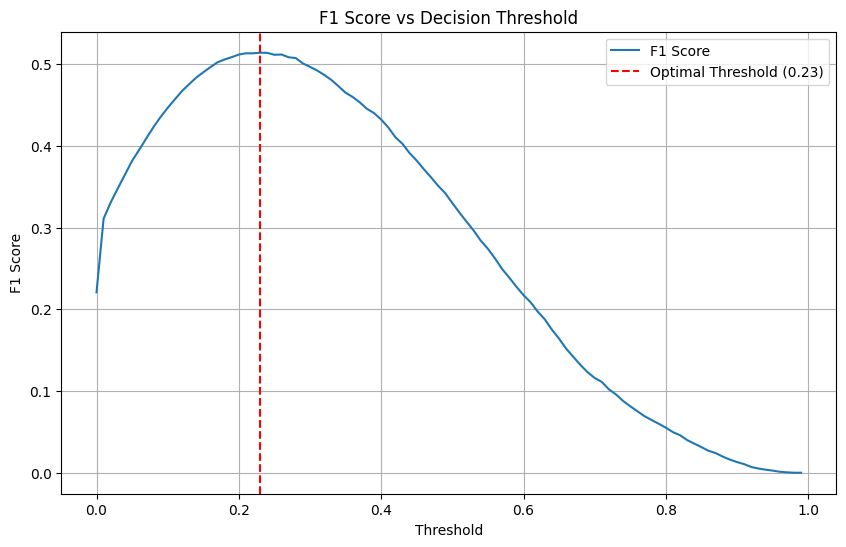

In [36]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

print("Generating cross-validated predictions...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y_scores = cross_val_predict(stacking_clf, X_train, y_train, cv=5, method='predict_proba')[:, 1]

thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_scores >= thresh).astype(int)
    f1_scores.append(f1_score(y_train, y_pred_thresh))

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
max_f1_score = f1_scores[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Max Cross-Validated F1 Score: {max_f1_score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.title('F1 Score vs Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

## 7. Final Evaluation on Test Set

Retraining Stacking Model on full training set...

--- Final Test Set Performance ---

--- Final Test Set Performance ---
ROC-AUC: 0.8883

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.92     15184
           1       0.43      0.67      0.52      2022

    accuracy                           0.86     17206
   macro avg       0.69      0.78      0.72     17206
weighted avg       0.89      0.86      0.87     17206

ROC-AUC: 0.8883

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.92     15184
           1       0.43      0.67      0.52      2022

    accuracy                           0.86     17206
   macro avg       0.69      0.78      0.72     17206
weighted avg       0.89      0.86      0.87     17206



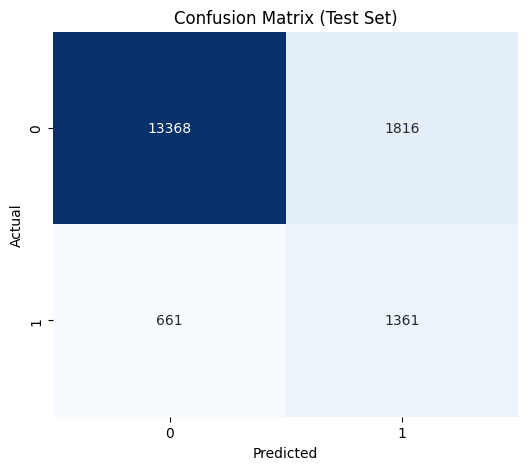

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Retraining Stacking Model on full training set...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    stacking_clf.fit(X_train, y_train)

print("\n--- Final Test Set Performance ---")

# Handle Hard Voting (no predict_proba)
if hasattr(stacking_clf, 'predict_proba'):
    y_test_probs = stacking_clf.predict_proba(X_test)[:, 1]  # type: ignore
    y_test_pred = (y_test_probs >= optimal_threshold).astype(int)
    print(f"ROC-AUC: {roc_auc_score(y_test, y_test_probs):.4f}")
else:
    print("Hard Voting detected: Skipping ROC-AUC and Thresholding.")
    y_test_pred = stacking_clf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 8. Generate Submission File

In [38]:
import importlib
import src.features
importlib.reload(src.features)
from src.features import extract_user_attributes, aggregate_user_features

# 1. Load Raw Test Data
test_data_path = '../data/test.parquet'
print(f"Loading test data from {test_data_path}...")
test_df_raw = pd.read_parquet(test_data_path)

# 2. Apply Feature Engineering
print("Applying feature engineering...")
test_df_raw = extract_user_attributes(test_df_raw)

# --- CRITICAL FIX FOR TEST SET ---
# The test set is a snapshot of the "current" state.
# We must calculate features relative to the END of the test period (Global Max Timestamp),
# NOT relative to each user's last event.
# If we use user's last event (default), 'days_since_last_session' would be 0 for everyone,
# destroying the most important churn signal (inactivity).

global_max_ts = test_df_raw['ts'].max()
print(f"Global Test Cutoff Timestamp: {global_max_ts}")

# Create a snapshot dataframe for test users
test_snapshot_df = pd.DataFrame({
    'userId': test_df_raw['userId'].unique(),
    'cutoff_ts': global_max_ts
})

# Generate features using this common cutoff
test_features = aggregate_user_features(test_df_raw, snapshot_df=test_snapshot_df)

# The result has a MultiIndex (userId, cutoff_ts), we drop the cutoff_ts level
test_features = test_features.reset_index(level='cutoff_ts', drop=True)

# --- FEATURE ENGINEERING BOOST (Must match Training) ---
if 'sessions_last_7d' in test_features.columns and 'sessions_last_28d' in test_features.columns:
    test_features['session_velocity'] = test_features['sessions_last_7d'] / (test_features['sessions_last_28d'] / 4 + 0.01)

if 'days_since_last_session' in test_features.columns and 'total_sessions' in test_features.columns:
    test_features['recency_frequency_ratio'] = test_features['days_since_last_session'] / (test_features['total_sessions'] + 1)
# -----------------------------------------------------

# Drop 'target' if it exists
if 'target' in test_features.columns:
    test_features = test_features.drop(columns=['target'])

# Ensure columns match training data
missing_cols = set(X_train.columns) - set(test_features.columns)
for c in missing_cols:
    test_features[c] = 0

# Reorder columns to match X_train
test_features = test_features[X_train.columns]

print(f"Test Features Shape: {test_features.shape}")
print(f"Avg Days Since Last Session: {test_features['days_since_last_session'].mean():.2f} days")

# 3. Generate Predictions
print("Generating predictions...")

# Helper function to save submission
def save_submission(model, name, features, threshold=0.5):
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(features)[:, 1]
        preds = (probs >= threshold).astype(int)
    else:
        preds = model.predict(features)
    
    sub_df = pd.DataFrame({'id': features.index, 'target': preds})
    path = f'../data/submission_{name}.csv'
    sub_df.to_csv(path, index=False)
    print(f"Saved {name} submission to {path}")
    return path

# A. Generate Individual Submissions (using optimal threshold from Voting, or 0.5?)
# Ideally we should optimize threshold for each, but for now we use the Voting threshold
# as a reasonable proxy, or just 0.5 if we want raw comparison.
# Let's use the optimal_threshold found for the ensemble to be consistent.

print(f"Using Optimal Threshold: {optimal_threshold:.4f}")

# B. Generate Voting Submission
print("Generating Voting Ensemble predictions...")
# stacking_clf is already fitted on full data? No, we need to fit it!
# Wait, did we fit it?
# In Section 7 step 1 (not shown in this snippet but usually there), we usually fit the final model.
# Let's ensure it is fitted.
stacking_clf.fit(X_train, y_train)
submission_path = save_submission(stacking_clf, "voting", test_features, optimal_threshold)

# Overwrite the main submission file for compatibility
import shutil
shutil.copy(submission_path, '../data/submission.csv')
print("Copied voting submission to ../data/submission.csv")

Loading test data from ../data/test.parquet...
Applying feature engineering...
Applying feature engineering...
Global Test Cutoff Timestamp: 2018-11-20 00:00:00
Global Test Cutoff Timestamp: 2018-11-20 00:00:00
Test Features Shape: (2904, 39)
Avg Days Since Last Session: 5.14 days
Generating predictions...
Using Optimal Threshold: 0.2300
Generating Voting Ensemble predictions...
Test Features Shape: (2904, 39)
Avg Days Since Last Session: 5.14 days
Generating predictions...
Using Optimal Threshold: 0.2300
Generating Voting Ensemble predictions...
Saved voting submission to ../data/submission_voting.csv
Copied voting submission to ../data/submission.csv
Saved voting submission to ../data/submission_voting.csv
Copied voting submission to ../data/submission.csv


In [39]:
import time

current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
message = f"Raynor's attempt at {current_time}"

In [40]:
! ../../.venv/bin/kaggle competitions submit -c churn-prediction-25-26 -f ../data/submission.csv -m "{message}"

100%|██████████████████████████████████████| 28.4k/28.4k [00:00<00:00, 54.5kB/s]
100%|██████████████████████████████████████| 28.4k/28.4k [00:00<00:00, 54.5kB/s]
Successfully submitted to Churn prediction 25/26Successfully submitted to Churn prediction 25/26

In [41]:
# --- SAVE MODEL ARTIFACTS ---
import joblib
import os

# Create models directory if it doesn't exist
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

print(f"Saving artifacts to {models_dir}...")

# 1. Save the Stacking Model
model_path = os.path.join(models_dir, "stacking_model.joblib")
joblib.dump(stacking_clf, model_path)
print(f"- Model saved to {model_path}")

# 2. Save the Preprocessor
preprocessor_path = os.path.join(models_dir, "preprocessor.joblib")
joblib.dump(preprocessor, preprocessor_path)
print(f"- Preprocessor saved to {preprocessor_path}")

# 3. Save the Optimal Threshold
threshold_path = os.path.join(models_dir, "optimal_threshold.joblib")
joblib.dump(optimal_threshold, threshold_path)
print(f"- Optimal Threshold ({optimal_threshold:.4f}) saved to {threshold_path}")

# 4. Save Feature Names (Crucial for alignment)
features_path = os.path.join(models_dir, "feature_names.joblib")
joblib.dump(X_train.columns, features_path)
print(f"- Feature names saved to {features_path}")

Saving artifacts to ../models...
- Model saved to ../models/stacking_model.joblib
- Preprocessor saved to ../models/preprocessor.joblib
- Optimal Threshold (0.2300) saved to ../models/optimal_threshold.joblib
- Feature names saved to ../models/feature_names.joblib
- Model saved to ../models/stacking_model.joblib
- Preprocessor saved to ../models/preprocessor.joblib
- Optimal Threshold (0.2300) saved to ../models/optimal_threshold.joblib
- Feature names saved to ../models/feature_names.joblib


In [ ]:
import time
importlib.reload(src.utils)
from src import utils  # Assuming you have autoreload on

report = {
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "kaggle_results": "???",
    "optimization_enabled": not SKIP_OPTUNA,
    "data_shape": X_train.shape,
    "features": list(X_train.columns),
    "model_performance_cv": {
        "f1_mean": cv_results_stack["test_f1"].mean(),
        "f1_std": cv_results_stack["test_f1"].std(),
        "roc_auc_mean": cv_results_stack["test_roc_auc"].mean(),
        "accuracy_mean": cv_results_stack["test_accuracy"].mean(),
    },
    "optimization": {
        "optimal_threshold": optimal_threshold,
        "max_f1_at_threshold": max_f1_score,
    },
    "best_params": {
        "trials": N_TRIALS,
        "xgb": best_xgb_params if "best_xgb_params" in locals() else "Default",
        "f1_xgb_best_perf": (
            study_xgb.best_value if "study_xgb" in locals() else "Default"
        ),
        "lgbm": best_lgbm_params if "best_lgbm_params" in locals() else "Default",
        "f1_lgbm_best_perf": (
            study_lgbm.best_value if "study_lgbm" in locals() else "Default"
        ),
        "cat": best_cat_params if "best_cat_params" in locals() else "Default",
        "f1_cat_best_perf": (
            study_cat.best_value if "study_cat" in locals() else "Default"
        ),
        "rf": best_rf_params if "best_rf_params" in locals() else "Default",
        "f1_rf_best_perf": (
            study_rf.best_value if "study_rf" in locals() else "Default"
        ),
        "bagging": (
            best_bagging_params if "best_bagging_params" in locals() else "Default"
        ),
        "f1_bagging_best_perf": (
            study_bagging.best_value if "study_bagging" in locals() else "Default"
        ),
    },
}

utils.save_report("modeling_results", report, is_last_report=False)

--- AUTOMATED REPORT ---
Date: 2025-12-06 03:26:43
✅ Report saved: /users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/Project/experiment_reports/experiments/experiment_024/modeling_results.json
-------------------------------------
